# Exercise 1

Increasing the epoch amount does not make the model predict better, if anything, it makes it worse. Increasing the amount of hidden layers in the LSTM seems to make the model predict better fitting data. I used 400 layers instead of the proposed 150. Possibly may cause some overfitting, but we can't be sure since there's so little data.

In [40]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
flight_data = sns.load_dataset("flights")
print(flight_data.head())
flight_data.shape

   year month  passengers
0  1949   Jan         112
1  1949   Feb         118
2  1949   Mar         132
3  1949   Apr         129
4  1949   May         121


(144, 3)

In [42]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [43]:
all_data = flight_data['passengers'].values.astype(float)

test_size = 12
train_data = all_data[:-test_size]
test_data= all_data[-test_size:]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 12

In [44]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [59]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=400, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
model1 = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
print(model1)

LSTM(
  (lstm): LSTM(1, 400)
  (linear): Linear(in_features=400, out_features=1, bias=True)
)


In [ ]:
epochs = 150


for i in range(epochs):
    
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model1.hidden_cell = (torch.zeros(1, 1, model1.hidden_layer_size),
                        torch.zeros(1, 1, model1.hidden_layer_size))

        y_pred = model1(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [86]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
model1.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model1.hidden = (torch.zeros(1, 1, model1.hidden_layer_size),
                        torch.zeros(1, 1, model1.hidden_layer_size))
        test_inputs.append(model1(seq).item())
        
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))



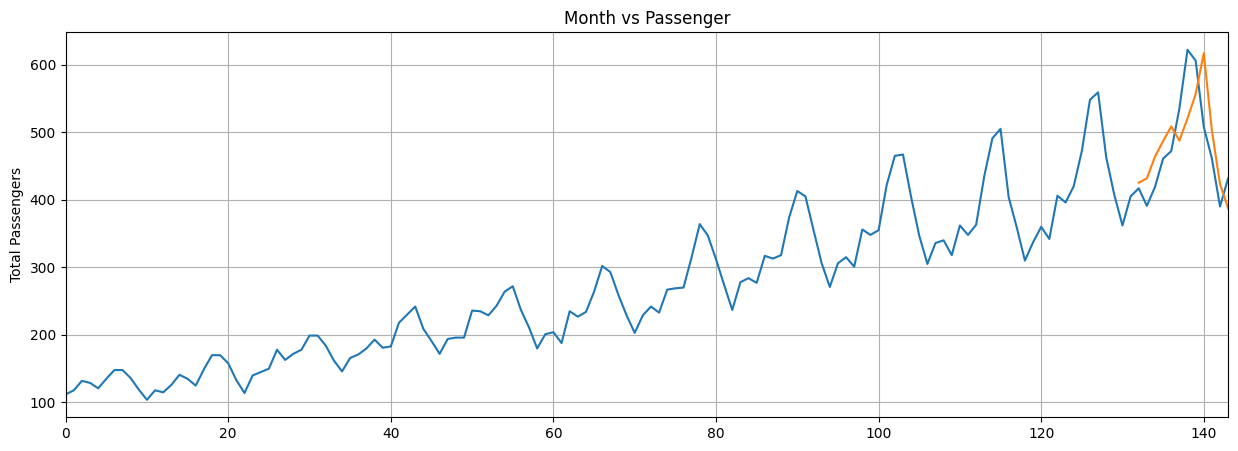

In [ ]:
x = np.arange(132, 144, 1)

plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(test_data)
plt.plot(actual_predictions1)
plt.show()

# Exercise 2

In [ ]:
import yfinance as yf
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

end = pd.to_datetime("today").strftime("%Y-%m-%d")
df = yf.download("BTC-USD", start="2016-01-01", end=end, interval="1d", progress=False)
df.to_csv("btc_usd_daily.csv") 

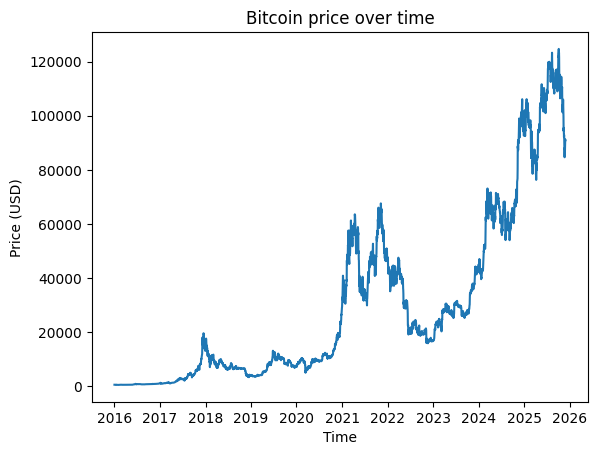

In [2]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.show()

### 1/ The multivariate data includes the daily volume traded, opening price, high price, and low price. The LSTM is trying to predict Bitcoin's price for the next 50 days.

### 2/ Since all the variables are all attached to the sales of bitcoin, it would make sense that they are at least somewhat correlated to one another. We can confirm by checking with scipy.

In [3]:
common = df.dropna()

from scipy import stats

#Chose variables at random
r_scipy, p_value = stats.pearsonr(common['High'].values, common['Open'].values)
print(r_scipy)
r_scipy, p_value = stats.pearsonr(common['High'].values, common['Low'].values)
print(r_scipy)
r_scipy, p_value = stats.pearsonr(common['Close'].values, common['Volume'].values)
print(r_scipy)


[0.99968065]
[0.99938983]
[0.67243879]


In [4]:
X, y = df.drop(columns=['Close']), df.Close.values

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1)) 

In [5]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()

In [7]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:] 

X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2])) 
print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([3322, 100, 4]) torch.Size([3322, 50])
Testing Shape: torch.Size([150, 100, 4]) torch.Size([150, 50])


In [13]:
class LSTM(nn.Module):
    
    def __init__(self, name, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        self.name = name
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [28]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 499 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item()),f"LSTM name: {lstm.name}") 
            


### In order to save time (it is an important resource), we will reduce the number of epochs to 500 and only focus on how the changed parameters will improve the model when compared to the original


### We create 2 different models, one with the original amount of hidden size and learning rate, another one with an increased amount of hidden size of 50, and half the learning rate for more stable training. The decreased MSE loss results seems to indicate that the modified params improved the results.

In [30]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 500
learning_rate = 0.001 # 0.001 lr
name = "Original"
input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm1 = LSTM(name,num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm1,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)



learning_rate = 0.0005 # half the learning rate
name = "Modified"
input_size = 4 # number of features
hidden_size = 50 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm2 = LSTM(name,num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm2.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm2,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.11821, test loss: 0.77260 LSTM name: Original
Epoch: 499, train loss: 0.00208, test loss: 0.00878 LSTM name: Original
Epoch: 0, train loss: 0.08789, test loss: 0.77178 LSTM name: Modified
Epoch: 499, train loss: 0.00173, test loss: 0.00277 LSTM name: Modified


### The produced graphs also reflect the higher accuracy of prediction.


In [39]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict1 = lstm1(df_X_ss) # forward pass
data_predict1 = train_predict1.data.numpy() # numpy conversion
dataY_plot1 = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict1) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot1)
true1, preds1 = [], []
for i in range(len(dataY_plot)):
    true1.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds1.append(data_predict[i][0])


train_predict2 = lstm2(df_X_ss) # forward pass
data_predict2 = train_predict2.data.numpy() # numpy conversion
dataY_plot2 = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict2) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot2)
true2, preds2 = [], []
for i in range(len(dataY_plot)):
    true2.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds2.append(data_predict[i][0])


start_idx = 3000

# ensure lists/arrays exist
true1 = np.asarray(true1)
preds1 = np.asarray(preds1)
preds2 = np.asarray(preds2)



true_slice = true1[start_idx:]
preds1_slice = preds1[start_idx: start_idx + len(true_slice)]
preds2_slice = preds2[start_idx: start_idx + len(true_slice)]

x = np.arange(start_idx, start_idx + len(true_slice))

plt.figure(figsize=(12,6))
plt.plot(x, true_slice, label='Actual Data')
plt.plot(x, preds1_slice, label='Original Predicted Data')
plt.plot(x, preds2_slice, label='Modified Predicted Data')
plt.title('Time-Series Prediction (from index %d to end)' % start_idx)
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') if train_test_cutoff >= start_idx else None
plt.xlim(start_idx, x[-1])
plt.legend()
plt.savefig("whole_plot_zoomed.png", dpi=300)
plt.show()




# Exercise 3


### We are still using the same data from exercise 1, only changes made are all sizes have been changed to 100, and added RNN and GRU models

In [ ]:
#LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
model1 = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

#Training the model
epochs = 150


for i in range(epochs):
    
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model1.hidden_cell = (torch.zeros(1, 1, model1.hidden_layer_size),
                        torch.zeros(1, 1, model1.hidden_layer_size))

        y_pred = model1(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()


#Predict
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
model1.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model1.hidden = (torch.zeros(1, 1, model1.hidden_layer_size),
                        torch.zeros(1, 1, model1.hidden_layer_size))
        test_inputs.append(model1(seq).item())
        
actual_predictions1 = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))



In [68]:
# LSTM error
loss_fn_lstm = nn.MSELoss()
total_error_lstm = 0.0

model1.eval()
with torch.no_grad():
    for seq, label in train_inout_seq:

        # LSTM requires (h, c)
        model1.hidden_cell = (
            torch.zeros(1, 1, model1.hidden_layer_size),
            torch.zeros(1, 1, model1.hidden_layer_size)
        )

        y_pred = model1(seq)

        # Shape-safe loss calculation
        try:
            loss = loss_fn_lstm(y_pred, label)
        except Exception:
            loss = loss_fn_lstm(y_pred.view(-1), label.view(-1))

        total_error_lstm += loss.item()

In [ ]:
#RNN model
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.RNN = nn.RNN(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        RNN_out, self.hidden_cell = self.RNN(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(RNN_out.view(len(input_seq), -1))
        return predictions[-1]
    
model2 = RNN()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

#Training the model
epochs = 150


for i in range(epochs):
    
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model2.hidden_cell = (torch.zeros(1, 1, model2.hidden_layer_size))

        y_pred = model2(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

#Prediction

fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
model2.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model2.hidden = (torch.zeros(1, 1, model2.hidden_layer_size))
        test_inputs.append(model2(seq).item())
        
actual_predictions2 = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))


In [67]:
#RNN error

loss_fn_rnn = nn.MSELoss()
total_error_rnn = 0.0
model2.eval()
with torch.no_grad():
    for seq, label in train_inout_seq:
        model2.hidden_cell = torch.zeros(1, 1, model2.hidden_layer_size)
        y_pred = model2(seq)
        try:
            loss = loss_fn_rnn(y_pred, label)
        except Exception:
            # fallback to matching shapes
            loss = loss_fn_rnn(y_pred.view(-1), label.view(-1))
        total_error_rnn += loss.item()


In [ ]:
#GRU model
class GRU(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size


        self.gru = nn.GRU(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)


        self.hidden_cell = torch.zeros(1, 1, self.hidden_layer_size)

    def forward(self, input_seq):
        self.hidden_cell = torch.zeros(1, 1, self.hidden_layer_size)

        gru_out, self.hidden_cell = self.gru(
            input_seq.view(len(input_seq), 1, -1),
            self.hidden_cell
        )

        predictions = self.linear(gru_out.view(len(input_seq), -1))
        return predictions[-1]


model3 = GRU()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

#Training the model
epochs = 150

for i in range(epochs):

    for seq, labels in train_inout_seq:
        optimizer.zero_grad()

        # GRU: only one hidden state
        model3.hidden_cell = torch.zeros(1, 1, model3.hidden_layer_size)

        y_pred = model3(seq)

        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()

#Predictions
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
model3.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():


        model3.hidden_cell = torch.zeros(1, 1, model3.hidden_layer_size)

        test_inputs.append(model3(seq).item())

actual_predictions3 = scaler.inverse_transform(
    np.array(test_inputs[train_window:]).reshape(-1, 1)
)

#Calculate error

In [71]:
#GRU error
loss_fn_gru = nn.MSELoss()
total_error_gru = 0.0
model3.eval()
with torch.no_grad():
    for seq, label in train_inout_seq:
        # reset GRU hidden state before each sequence
        model3.hidden_cell = torch.zeros(1, 1, model3.hidden_layer_size)
        y_pred = model3(seq)
        try:
            loss = loss_fn_gru(y_pred, label)
        except Exception:
            # fallback to matching shapes
            loss = loss_fn_gru(y_pred.view(-1), label.view(-1))
        total_error_gru += loss.item()


### At first glance, GRU may have better prediction, but the error does ultimately prove that RNN has the lowest error.

In [70]:
print(f"LSTM Error: {total_error_lstm}")
print(f"RNN Error: {total_error_rnn}")
print(f"GRU Error: {total_error_gru}")
x = np.arange(132, 144, 1)

plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'],label = "Original signal")
plt.plot(x,actual_predictions1, label = "LSTM prediction")
plt.plot(x,actual_predictions2, label = "RNN prediction")
plt.plot(x,actual_predictions3, label = "GRU prediction")
plt.legend()
plt.show()

LSTM Error: 32.4095722931757
RNN Error: 0.8473606490566965
GRU Error: 1.4416662567179515


# Exercise 4a


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Mean Squared Error: 0.5385446422423639
R-squared: 0.5966234519623754


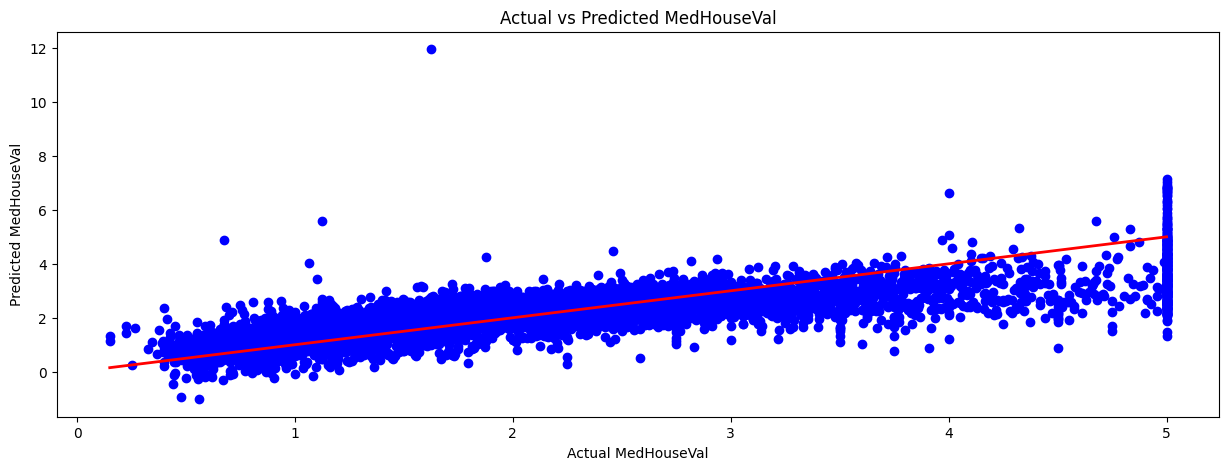

In [82]:
# Load the dataset
housing = fetch_california_housing()

# Create a DataFrame
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target

# Define features and target variable
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

# Create the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R-squared:', r2)

plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Actual MedHouseVal')
plt.ylabel('Predicted MedHouseVal')
plt.title('Actual vs Predicted MedHouseVal')
plt.show()

# Exercise 4b


### Error and R-Squared results indicate the the Linear Regression is better than the LSTM model itself. The poor performance from LSTM could stem from the fact that, again, there is so few data to train off of, so Linear Regression outshines it in this scenario.

LSTM Mean Squared Error: 24938.436505608668
LSTM R-squared: -3.5019517212425573
LinearRegression Mean Squared Error: 3225.602154790616
LinearRegression R-squared: 0.8413553218906038


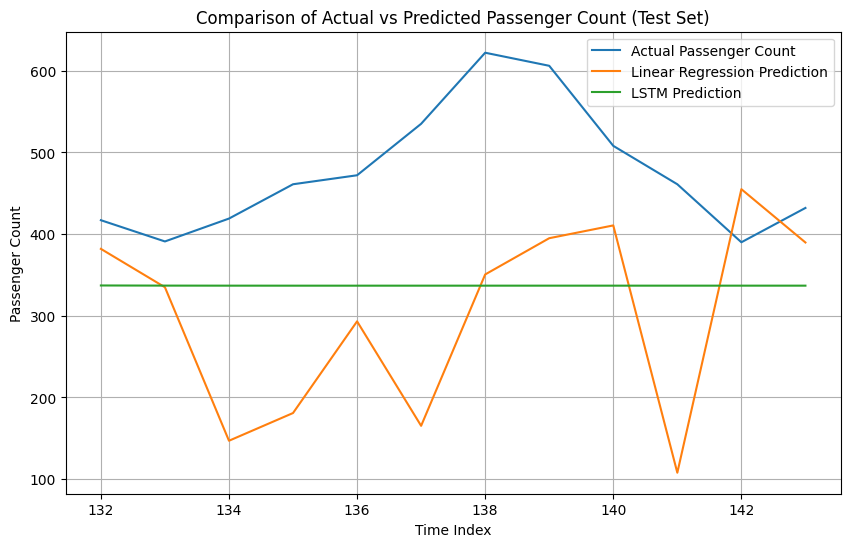

In [89]:
flight_data = sns.load_dataset("flights")

all_data = flight_data["passengers"]

X = np.arange(len(all_data)).reshape(-1, 1) 
y = all_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=12, random_state=25)

# Create the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)


mse_lstm = mean_squared_error(test_data, actual_predictions.flatten())
r2_lstm = r2_score(test_data, actual_predictions.flatten())

print('LSTM Mean Squared Error:', mse_lstm)
print('LSTM R-squared:', r2_lstm)

# For LinearRegression (from latest cell)
print('LinearRegression Mean Squared Error:', mse)
print('LinearRegression R-squared:', r2)

test_indices = np.arange(len(all_data) - 12, len(all_data))

plt.figure(figsize=(10, 6))
plt.plot(test_indices, test_data, label='Actual Passenger Count', )
plt.plot(test_indices, y_pred, label='Linear Regression Prediction')
plt.plot(test_indices, actual_predictions.flatten(), label='LSTM Prediction')
plt.xlabel('Time Index')
plt.ylabel('Passenger Count')
plt.title('Comparison of Actual vs Predicted Passenger Count (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 5

### In essence, the autoencoder is being trained on heartbeat data that has been compressed into a lower dimension to learn what "normal" looks like. Afterwards, the autoencoder attempts to reconstruct the original heartbeat data after learning from the compressed data. From the reconstruction, we can detect whether the reconstruction is an anomaly or not depending on the error between the reconstruction and original data, depending on a set threshold.

### Batching was added into the code (explained below) to boost speed.

### To improve speed, instead of doing 40 thousand forward passes per epoch, do a significantly smaller number like 400. We can also, for example, take 60 heartbeats at once, run the model once with all of them, then compute the loss for all 60 instead of running the model for every heartbeat which is EXTREMELY SLOW



### To monitor on the fly, we can monitor how long each epoch takes, a quick internet search also suggests monitoring GPU usage (better and quicker model should use less GPU), TensorBoard, etc. also allow to monitor live progress, loss curves and speeds (not implemented in this code).


C:\Users\haina\AppData\Local\Temp\ipykernel_23032\1519171472.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(class_names)


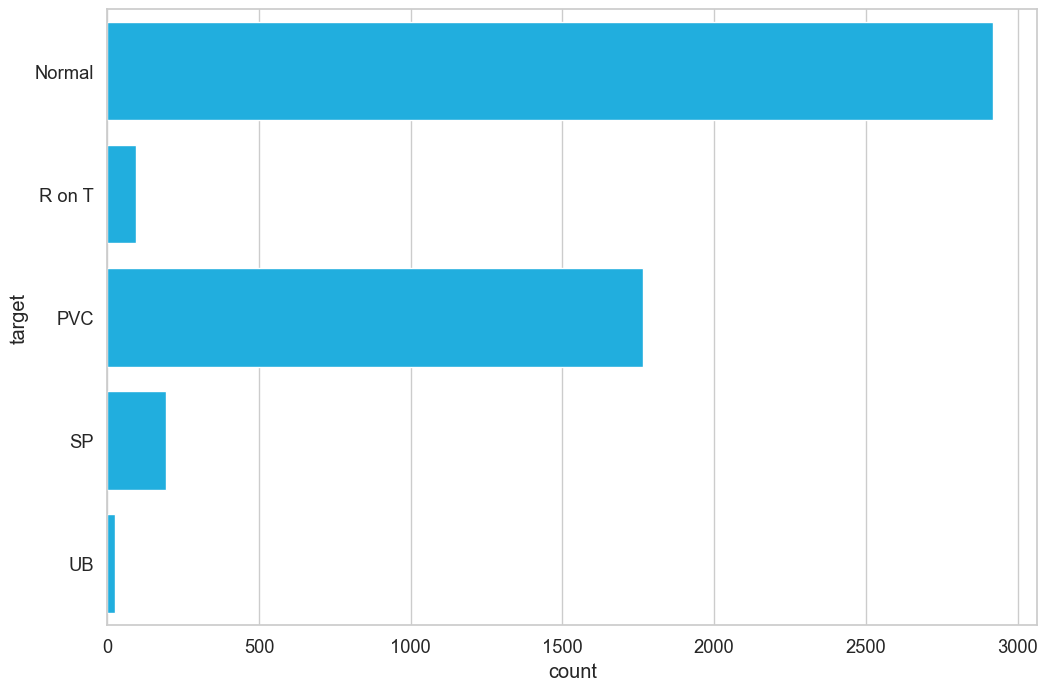

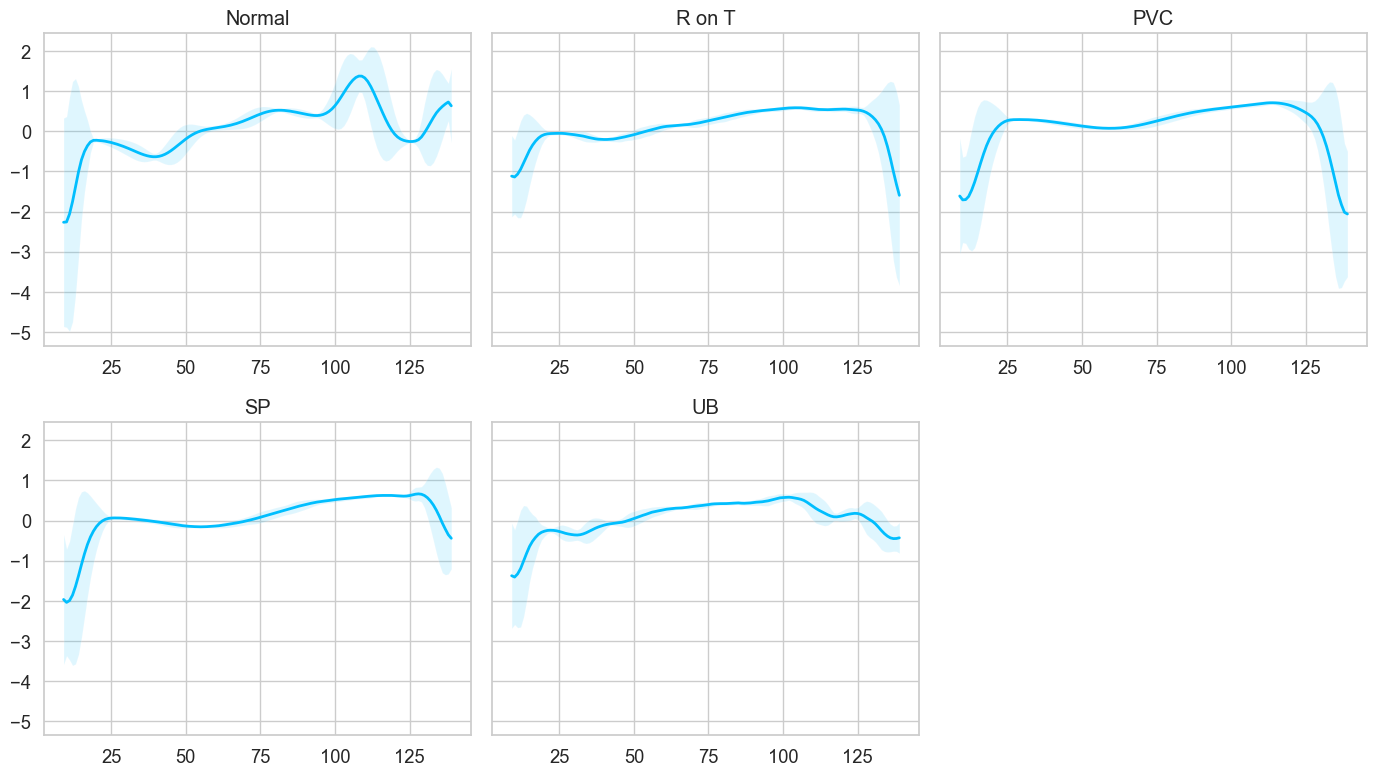

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  4 14:54:51 2024

@author: turunenj
"""
#https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/


#!pip install -qq arff2pandas
#!pip install -q -U watermark
#!pip install -qq -U pandas
#!pip install -q tqdm

#%reload_ext watermark
#%watermark -v -p numpy,pandas,torch,arff2pandas

###Load data

#!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
#!unzip -qq ECG5000.zip

import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from scipy.io import arff

from torch.utils.data import Dataset, DataLoader

import time


#Definitions
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load training data
train_data, train_meta = arff.loadarff('./ECG5000/ECG5000_TRAIN.arff')
train = pd.DataFrame(train_data)

# Load test data
test_data, test_meta = arff.loadarff('./ECG5000/ECG5000_TEST.arff')
test = pd.DataFrame(test_data)
#We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:
#df = train.append(test) #not working an ymore
df=pd.concat([train,test],ignore_index=True)

df = df.sample(frac=1.0, random_state=RANDOM_SEED)

#We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

#Next, we'll rename the last column to target, so its easier to reference it:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
df['target'] = df['target'].str.decode('utf-8')
###Exploratory Data Analysis
#Let's check how many examples for each heartbeat class do we have:


#Let's plot the results:
ax = sns.countplot(df.target)
#seaborn sometimes make horizontal bars sometime vertical
#based on df.target orientation, change the next rows, if necessary:

#ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.show()
#The normal class, has by far, the most examples. This is great because we'll use it to train our model.

#Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout()

###LSTM Autoencoder

#The Autoencoder's job is to get some input data, pass it through the model, and obtain a reconstruction of the input. 
#The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, 
#so your model learns a compressed representation of the data.

#In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. 
#Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers 
#(hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

#To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.
#Reconstruction Loss

#When training an Autoencoder, the objective is to reconstruct the input as best as possible. 
#This is done by minimizing a loss function (just like in supervised learning). 
#This function is known as reconstruction loss. Cross-entropy loss and Mean squared error are common examples.

#Anomaly Detection in ECG Data

#We'll use normal heartbeats as training data for our model and record the reconstruction loss. But first, 
#we need to prepare the data:
    
#Data Preprocessing

#Let's get all normal heartbeats and drop the target (class) column:
    
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)

#We'll merge all other classes and mark them as anomalies:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)


#We'll split the normal examples into train, validation and test sets:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)
    
# We will replace the old create_dataset that returned a list of single-sample tensors
# with a Dataset + DataLoader approach so we can batch efficiently.

class ECGDataset(Dataset):
    """
    Simple Dataset expecting a pandas DataFrame where each row is one time series (length seq_len).
    Returns tensors with shape: [seq_len, 1] so DataLoader will stack into [batch, seq_len, 1].
    """
    def __init__(self, df):
        self.data = df.astype(np.float32).values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]                      # shape: (seq_len,)
        x = torch.tensor(x).unsqueeze(1).float()  # -> (seq_len, 1)
        return x

# Keep seq_len and n_features consistent with the dataset
seq_len = train_df.shape[1]
n_features = 1

# Create DataLoaders (batching happens here)
BATCH_SIZE = 64
train_loader = DataLoader(ECGDataset(train_df), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(ECGDataset(val_df), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_normal_loader = DataLoader(ECGDataset(test_df), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_anomaly_loader = DataLoader(ECGDataset(anomaly_df), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

#The general Autoencoder architecture consists of two components. An Encoder that compresses the input and 
#a Decoder that tries to reconstruct it.

# We'll modify the Encoder/Decoder to accept batched input.
# We'll preserve the spirit of the original architecture (two LSTM layers in encoder/decoder),
# but make them batch-aware: inputs and outputs will have a batch dimension.

#We'll use the LSTM Autoencoder from this GitHub repo with some small tweaks. 
#Our model's job is to reconstruct Time Series data. Let's start with the Encoder:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    # batch_first=True because our inputs will be [batch, seq_len, n_features]
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    # x expected shape: [batch, seq_len, n_features]
    # Pass through first LSTM: output shape [batch, seq_len, hidden_dim]
    x, _ = self.rnn1(x)
    # Pass through second LSTM: output shape [batch, seq_len, embedding_dim]
    x, (hidden_n, _) = self.rnn2(x)
    # hidden_n shape: (num_layers, batch, embedding_dim) -> squeeze num_layers
    # return shape: [batch, embedding_dim]
    hidden_n = hidden_n.squeeze(0)
    return hidden_n  # batch of embeddings

#The Encoder uses two LSTM layers to compress the Time Series data input.
#Next, we'll decode the compressed representation using a Decoder:

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    # decoder receives sequences of shape [batch, seq_len, input_dim]
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    # x is embedding tensor with shape [batch, input_dim]
    batch_size = x.shape[0]
    # repeat embedding across time dimension to create sequence input to decoder
    # -> [batch, seq_len, input_dim]
    x = x.unsqueeze(1).repeat(1, self.seq_len, 1)

    # pass through decoder RNNs
    x, _ = self.rnn1(x)
    x, _ = self.rnn2(x)  # -> [batch, seq_len, hidden_dim]

    # Apply output layer time-step wise (linear over last dim)
    x = self.output_layer(x)  # -> [batch, seq_len, n_features]

    return x



#Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.
#Time to wrap everything into an easy to use module:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    # Note: We don't .to(device) here so the whole model can be moved by the caller
    self.encoder = Encoder(seq_len, n_features, embedding_dim)
    self.decoder = Decoder(seq_len, embedding_dim, n_features)

  def forward(self, x):
    # x shape: [batch, seq_len, n_features]
    emb = self.encoder(x)          # [batch, embedding_dim]
    x_rec = self.decoder(emb)      # [batch, seq_len, n_features]
    return x_rec

#Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

def train_model(model, train_loader, val_loader, n_epochs):
  """
  train_loader/val_loader are DataLoader instances that yield batches with shape:
    batch -> [batch, seq_len, n_features]
  """
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  # We'll keep the original L1 (MAE) loss and keep reduction='sum' to mirror previous numeric behavior.
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float('inf')
  
  for epoch in range(1, n_epochs + 1):
    model.train()

    train_losses = []
    epoch_start = time.time()

    total_train_loss = 0.0
    total_train_samples = 0

    for batch in train_loader:
      optimizer.zero_grad()

      # batch: [batch, seq_len, n_features]
      batch = batch.to(device)
      seq_pred = model(batch)

      loss = criterion(seq_pred, batch)   # sum over elements in batch
      loss.backward()
      optimizer.step()

      # record losses: to be comparable with earlier code which appended loss.item() per sample,
      # we append average loss per sample for the batch (sum / batch_size)
      batch_sum = loss.item()
      batch_n = batch.shape[0]
      total_train_loss += batch_sum
      total_train_samples += batch_n

      avg_batch_loss = batch_sum / batch_n
      train_losses.append(avg_batch_loss)



    # Validation
    model.eval()
    val_losses = []
    total_val_loss = 0.0
    total_val_samples = 0

    with torch.no_grad():
      for batch in val_loader:
        batch = batch.to(device)
        seq_pred = model(batch)
        loss = criterion(seq_pred, batch)

        batch_sum = loss.item()
        batch_n = batch.shape[0]
        total_val_loss += batch_sum
        total_val_samples += batch_n

        val_losses.append(batch_sum / batch_n)

    # Compute epoch-level average losses (mean per-sample losses)
    train_loss = total_train_loss / total_train_samples if total_train_samples > 0 else np.mean(train_losses)
    val_loss = total_val_loss / total_val_samples if total_val_samples > 0 else np.mean(val_losses) if val_losses else 0.0

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    epoch_time = time.time() - epoch_start
    print(f'Epoch {epoch}: train loss {train_loss:.4f} val loss {val_loss:.4f}  (epoch time: {epoch_time:.2f}s)')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

#At each epoch, the training process feeds our model with all training examples and evaluates 
#the performance on the validation set. Note that we're using DataLoader now (batching).
#We also record the training and validation set losses during the process.

#Note that we're minimizing the L1Loss, which measures the MAE (mean absolute error). 
#Why? The reconstructions seem to be better than with MSE (mean squared error).

#We'll get the version of the model with the smallest validation error. Let's do some training:
    


### Tested with epoch = 5 just to see results time; considerably less time is need per epoch => Improvements

Epoch 1: train loss 93.2397 val loss 93.2107  (epoch time: 21.46s)
Epoch 2: train loss 90.4322 val loss 88.1935  (epoch time: 22.51s)
Epoch 3: train loss 80.9237 val loss 88.5684  (epoch time: 23.59s)
Epoch 4: train loss 85.6929 val loss 80.5309  (epoch time: 24.38s)
Epoch 5: train loss 81.9277 val loss 76.6912  (epoch time: 24.02s)


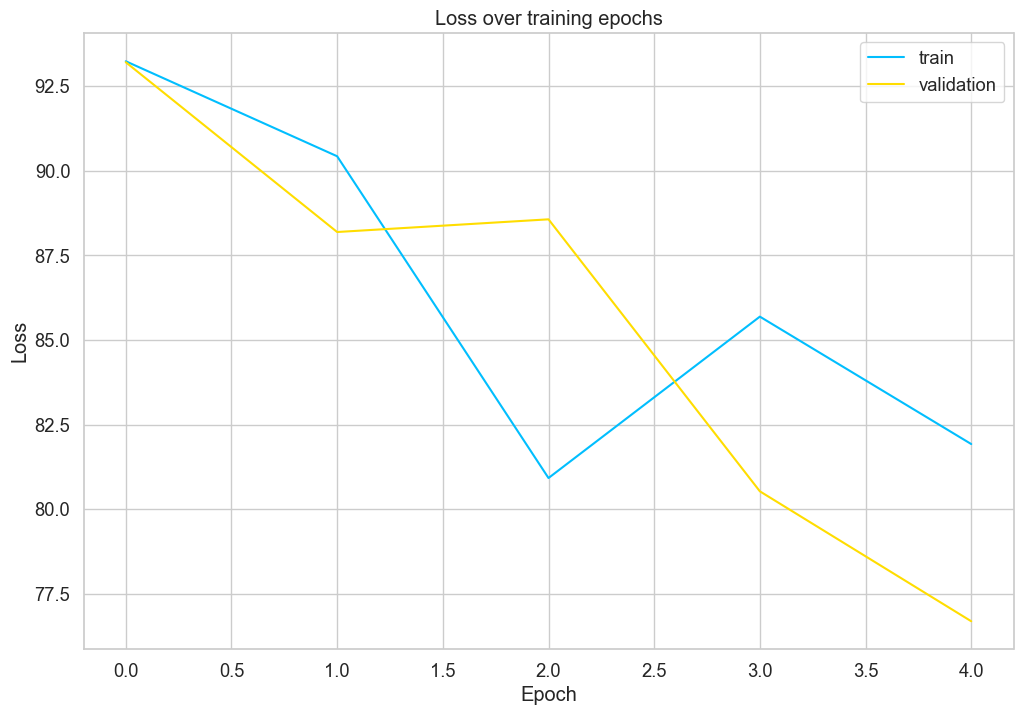

Correct normal predictions: 0/145
Correct anomaly predictions: 145/145


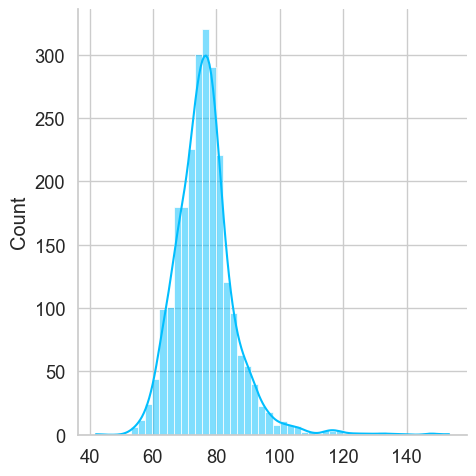

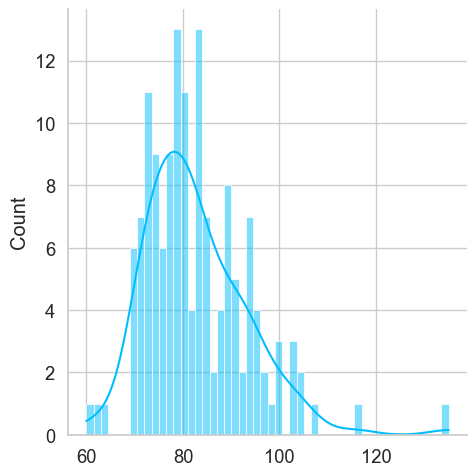

In [3]:
model, history = train_model(
  model, 
  train_loader, 
  val_loader, 
  n_epochs=5
)

#Then plot the learning curves:
    
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.title('Loss over training epochs')
plt.show()

#Let's store the model for later use:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

#With our model at hand, we can have a look at the reconstruction error on the training set. 
#Let's start by writing a helper function to get predictions from our model:

def predict(model, data_loader):
  """
  data_loader yields batches of shape [batch, seq_len, n_features].
  Returns per-sample predictions (list of 1D arrays) and per-sample losses (list of floats).
  """
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for batch in data_loader:
      batch = batch.to(device)
      preds = model(batch)  # [batch, seq_len, n_features]
      # compute per-batch sum loss
      batch_loss_sum = criterion(preds, batch).item()
      batch_size = batch.shape[0]

      # per-sample loss = batch_loss_sum / batch_size  (this is L1 sum averaged per sample)
      # but to be exact per-sample loss for each sample, compute L1 per sample:
      # compute absolute difference and sum over seq_len and features
      per_sample_losses = torch.sum(torch.abs(preds - batch), dim=(1,2)).cpu().numpy().tolist()

      # store per-sample predictions (flatten each sample)
      preds_cpu = preds.cpu().numpy()
      for i in range(batch_size):
        predictions.append(preds_cpu[i].flatten())
        losses.append(per_sample_losses[i])

  return predictions, losses

#Our function goes through each example in the dataset and records the predictions and losses. 
#Let's get the losses and have a look at them:
    
_, losses = predict(model, train_loader)

sns.displot(losses, bins=50, kde=True)
#Lets us make a threshold based on previous image
THRESHOLD = 26

#Evaluation
#Using the threshold, we can turn the problem into a simple binary classification task:

#    If the reconstruction loss for an example is below the threshold, we'll classify it as a normal heartbeat
#    Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

#Normal hearbeats

#Let's check how well our model does on normal heartbeats. 
#We'll use the normal heartbeats from the test set (our model haven't seen those):
predictions, pred_losses = predict(model, test_normal_loader)
sns.displot(pred_losses, bins=50, kde=True)
#We'll count the correct predictions:

correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(pred_losses)}')

#Anomalies
#We'll do the same with the anomaly examples, but their number is much higher. 
#We'll get a subset that has the same size as the normal heartbeats:
# To keep parity with previous code, sample the same number of anomaly examples as normal test samples:
num_normal_test = len(pred_losses)
# create a smaller anomaly loader if needed:
anomaly_list = list(test_anomaly_loader)  # list of batches
# flatten anomaly batches into per-sample tensors to be able to slice the first N samples
anomaly_samples = []
for batch in anomaly_list:
    for i in range(batch.shape[0]):
        anomaly_samples.append(batch[i])

anomaly_samples = anomaly_samples[:num_normal_test]
# Build a DataLoader from these selected anomaly samples
anomaly_subset_loader = DataLoader(anomaly_samples, batch_size=BATCH_SIZE, shuffle=False)

predictions, pred_losses = predict(model, anomaly_subset_loader)
sns.displot(pred_losses, bins=50, kde=True)

#Finally, we can count the number of examples above the threshold (considered as anomalies):
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(pred_losses)}')

#Looking at Examples
#We can overlay the real and reconstructed Time Series values to see how close they are. 
#We'll do it for some normal and anomaly cases:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, DataLoader([data], batch_size=1))
  ax.plot(data.numpy().flatten(), label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

# Note: test_normal_loader/test_anomaly_loader yield batches -> to index first 6 samples we convert to lists
test_normal_samples = []
for batch in test_normal_loader:
    for i in range(batch.shape[0]):
        test_normal_samples.append(batch[i])
test_anomaly_samples = []
for batch in test_anomaly_loader:
    for i in range(batch.shape[0]):
        test_anomaly_samples.append(batch[i])

for i, data in enumerate(test_normal_samples[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_samples[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout()
